请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 

In [1]:
import os
#加载一下数据集
if not os.path.exists('work/emo'):
    !unzip -o -q -d /home/aistudio/work data/data300323/emo-visual-data.zip

In [2]:
#导入需要的库
import random                      
import numpy as np                 
import os
from PIL import Image             
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import matplotlib.pyplot as plt    
import cv2                         
import paddle.nn.functional as F
# 深度学习包
import paddle
import paddle.nn as nn
import paddle.vision.transforms as T       
from paddle.io import Dataset, DataLoader

In [3]:
#创建数据表
if not os.path.exists('work/pic.txt'):
    wholefilenames=(os.listdir('work/emo'))
    nailongfilenames=(os.listdir('work/nailong'))
    for each_file in wholefilenames[:1000]:
        with open('work/pic.txt','a',encoding = 'utf-8') as file:
            file.writelines("work/emo/"+each_file+' '+'0'+'\n')
    for each_file in nailongfilenames:
        with open('work/pic.txt','a',encoding = 'utf-8') as file:
            file.writelines("work/nailong/"+each_file+' '+'1'+'\n')

In [4]:
train_ratio = 0.7  # 训练集占0.9，验证集占0.1
train_paths, train_labels = [], []
valid_paths, valid_labels = [], []
with open('work/pic.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        if random.uniform(0, 1) < train_ratio:
            train_paths.append(line.split()[0])
            label = int(line.split()[1])
            train_labels.append(int(line.split()[1]))
        else:
            valid_paths.append(line.split()[0])
            valid_labels.append(int(line.split()[1]))
print(len(valid_paths),len(valid_labels))

364 364


In [5]:
class TrainData(Dataset):
    '''概述 Dataset 的方法和行为的抽象类。映射式（map-style）数据集需要继承这个基类，映射式数据集为可以通过一个键值索引并获取指定样本的数据集，所有映射式数据集须实现以下方法：
        __getitem__：根据给定索引获取数据集中指定样本，在 paddle.io.DataLoader 中需要使用此函数通过下标获取样本。
        __len__：返回数据集样本个数，paddle.io.BatchSampler 中需要样本个数生成下标序列。'''
    def __init__(self):
        super().__init__()
        '''以下是数据增强'''
        self.color_jitter = T.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05)#随机调整图像的亮度、对比度、饱和度和色调。
        self.normalize = T.Normalize(mean=0, std=1)#用均值和标准差归一化输入数据。
        self.random_crop = T.RandomCrop(400, pad_if_needed=True)#在随机位置裁剪输入的图像。
        self.resize = T.Resize(size=(128, 128))
        #size (sequence|int) - 裁剪后的图片大小。如果 size 是一个 int 值，而不是(h, w)这样的序列，那么会做一个方形的裁剪(size, size)。
        #pad_if_needed (boolean，可选) - 如果裁剪后的图像小于期望的大小时，是否对裁剪后的图像进行填充，以避免引发异常，默认值：False，保持初次裁剪后的大小，不填充。
    
    def __getitem__(self, index):
        # 读取图片
        image_path = train_paths[index]
        image = np.array(Image.open(image_path))    # H, W, C
        try:
            image = image.transpose([2, 0, 1])[:3]  # C, H, W(把通道数调到最前面)
        except:
            image = np.array([image, image, image]) # C, H, W
        
        # 图像增广
        features = self.color_jitter(image.transpose([1, 2, 0]))# 输入的图像数据，数据格式为'HWC'，再调
        features = self.random_crop(features)
        #features = self.normalize(features.transpose([2, 0, 1])).astype(np.float32)#调回去呗
        features = self.resize(features).transpose([2, 0, 1]).astype(np.float32)
        # 读取标签
        labels = train_labels[index]
        
        return features, labels
    
    def __len__(self):
        return len(train_paths)

    
# 定义验证数据集
class ValidData(Dataset):
    def __init__(self):
        super().__init__()
        self.normalize = T.Normalize(mean=0, std=1)
    
    def __getitem__(self, index):
        # 读取图片
        image_path = valid_paths[index]

        image = np.array(Image.open(image_path))    # H, W, C
        try:
            image = image.transpose([2, 0, 1])[:3]  # C, H, W
        except:
            image = np.array([image, image, image]) # C, H, W
        
        # 图像变换
        features = cv2.resize(image.transpose([1, 2, 0]), (128, 128)).transpose([2, 0, 1]).astype(np.float32)
        features = self.normalize(features)

        # 读取标签
        labels = valid_labels[index]

        return features, labels
    
    def __len__(self):
        return len(valid_paths)

(3, 128, 128)


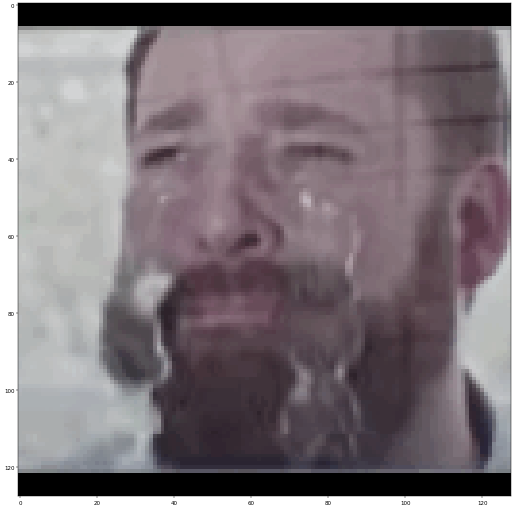

In [6]:
train_data = TrainData()
img, labels = train_data.__getitem__(98)
print(img.shape)
plt.figure(dpi=40,figsize=(16,16))
plt.imshow(img.astype(np.uint8).transpose([1, 2, 0]))
plt.show()

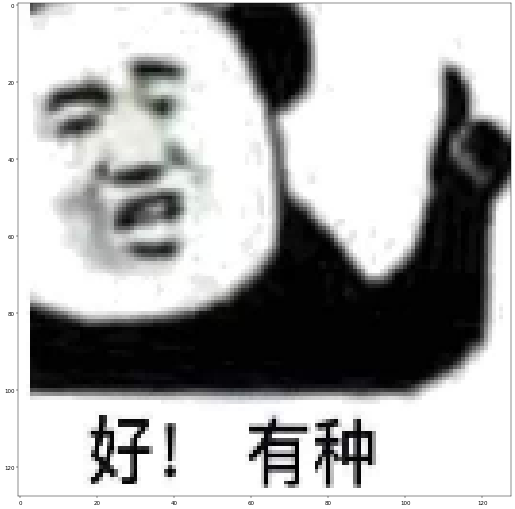

In [7]:
valid_data = ValidData()
img, label = valid_data.__getitem__(14)
plt.figure(dpi=40,figsize=(16,16))
plt.imshow(img.astype(np.uint8).transpose([1, 2, 0]))

In [8]:
paddle.vision.set_image_backend('cv2')#backend (str) - 加载图像的后端，必须为 pil 或者 cv2 。
model = paddle.vision.models.resnet50(pretrained=False, num_classes=2)
#model.fc = nn.Sequential(
#    nn.Linear(2048,50),
#    nn.Dropout()
#)
# 定义数据迭代器
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
#batch_size (int|None，可选) - 每 mini-batch 中样本个数，一捆一捆训练的

# 定义优化器
opt = paddle.optimizer.Adam(learning_rate=1e-4, parameters=model.parameters(), weight_decay=paddle.regularizer.L2Decay(1e-4))
#L2正则化，防止过拟合

# 定义损失函数
loss_fn = paddle.nn.CrossEntropyLoss()

# 设置gpu环境
paddle.set_device('gpu:0')
#EH的代码是在服务器上跑的，记得用有GPU的服务器。

# 整体训练流程
epoch = 10
best_acc = 0
for epoch_id in range(epoch):
    model.train()#模型启动训练模式
    for batch_id, data in enumerate(train_dataloader()):
        # 读取数据
        features, labels = data
        features = paddle.to_tensor(features)
        labels = paddle.to_tensor(labels)
        #labels = paddle.unsqueeze(labels, axis=1)  # 在第0维增加
        #print(labels.shape)
        #print(features.shape, labels)
        # 前向传播
        predicts = model(features)
        #print(predicts)
        # 损失计算
        loss = loss_fn(predicts, labels)
        #print(loss)
        # 反向传播
        avg_loss = paddle.mean(loss)
        avg_loss.backward()
        # 更新
        opt.step()

        # 清零梯度
        opt.clear_grad()

        # 打印损失
        if batch_id % 5 == 0:
            print('epoch_id:{}, batch_id:{}, loss:{}'.format(epoch_id, batch_id, avg_loss.numpy()))
    model.eval()
    print('开始评估')
    i = 0
    acc = 0
    
    for image, label in valid_data:
        image = paddle.to_tensor([image])

        pre = list(np.array(model(image)[0]))
        max_item = max(pre)
        pre = pre.index(max_item)

        i += 1
        if pre == label:
            acc += 1
    print('精度：', acc / i)
    if acc>best_acc or (acc / i)>0.9:
        paddle.save(model.state_dict(), 'acc{}.model'.format(acc / i))
        best_acc = acc

W1025 22:45:18.288543 201636 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 12.0, Runtime API Version: 11.8
W1025 22:45:18.289958 201636 gpu_resources.cc:164] device: 0, cuDNN Version: 8.9.
/opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/paddle/nn/layer/norm.py:788: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


epoch_id:0, batch_id:0, loss:0.9834334254264832
epoch_id:0, batch_id:5, loss:0.5797175765037537
epoch_id:0, batch_id:10, loss:0.4542827010154724
epoch_id:0, batch_id:15, loss:0.46486854553222656
epoch_id:0, batch_id:20, loss:0.401281476020813
epoch_id:0, batch_id:25, loss:0.40646910667419434
开始评估
精度： 0.8296703296703297
epoch_id:1, batch_id:0, loss:0.4657881557941437
epoch_id:1, batch_id:5, loss:0.24662503600120544
epoch_id:1, batch_id:10, loss:0.4287983179092407
epoch_id:1, batch_id:15, loss:0.3727388381958008
epoch_id:1, batch_id:20, loss:0.23270545899868011
epoch_id:1, batch_id:25, loss:0.6401547789573669
开始评估
精度： 0.8351648351648352
epoch_id:2, batch_id:0, loss:0.5685218572616577
epoch_id:2, batch_id:5, loss:0.3163226842880249
epoch_id:2, batch_id:10, loss:0.26427072286605835
epoch_id:2, batch_id:15, loss:0.19286829233169556
epoch_id:2, batch_id:20, loss:0.6003327369689941
epoch_id:2, batch_id:25, loss:0.20625638961791992
开始评估
精度： 0.6208791208791209
epoch_id:3, batch_id:0, loss:0.408